In [ ]:
pip install keras_applications 

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [16]:
def Global_attention_block(inputs):
    shape=K.int_shape(inputs)
    
    x=tf.keras.layers.AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('relu') (x)

    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('sigmoid') (x)
    C_A=tf.keras.layers.Multiply()([x,inputs])
    
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True)) (C_A)
    x=Activation('sigmoid') (x)
    S_A=tf.keras.layers.Multiply()([x,C_A])
    return S_A

def Category_attention_block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F=Conv2D(k*classes,1, padding='same') (inputs)
    F=tf.keras.layers.BatchNormalization() (F)
    F1=Activation('relu') (F)
    
    F2=F1
    x=tf.keras.layers.GlobalMaxPool2D()(F2)
    
    x=tf.keras.layers.Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    
    x=tf.keras.layers.Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    x=tf.keras.layers.Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (x)
    
    semantic=tf.keras.layers.Multiply()([inputs,M])
    return semantic

In [19]:
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')
    
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=tf.keras.applications.InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='efficientnetB0':
        base_model = tf.keras.applications.EfficientNetB0 (include_top=False, weights = 'imagenet',input_shape = (image_size,image_size,3))
    if model_name =='efficientNetV2B0':
        base_model = tf.keras.applications.EfficientNetV2B0 (include_top=False, weights = 'imagenet',input_shape = (image_size,image_size,3))
    if model_name =='nasnet':
        base_model=tf.keras.applications.NASNetMobile (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    
    return base_model

def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    
    dataParam={'messidor': [960,240,2,'../content/drive/MyDrive/Dataset/Messidor_512/train',
                            '../content/drive/MyDrive/Dataset/Messidor_512/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "mobilenetv2+CABNet.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 64)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [20]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"    
loss_fun= 'binary_crossentropy'  
gpu_num=1
k=3
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=512
classes=2

base_model=get_base_model('mobilenetv2',image_size)  
base_in=base_model.input
base_out=base_model.output

shape = K.int_shape(base_out)
channel_val = shape[3]/2
red_feat = tf.keras.layers.Conv2D(channel_val,1,padding='same')(base_out)
x=Global_attention_block(red_feat)
base_out = Category_attention_block(x,classes,k)
 
x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
parallel_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                             

In [21]:
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'mobilenetv2',
                                     lr1,lr2,1,80)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
60/60 [==============================] - ETA: 0s - loss: 0.7156 - acc: 0.5667
Epoch 1: acc improved from -inf to 0.56667, saving model to mobilenetv2+CABNet.hdf5
60/60 [==============================] - 56s 834ms/step - loss: 0.7156 - acc: 0.5667 - lr: 0.0050
Epoch 1/80
60/60 [==============================] - ETA: 0s - loss: 0.7031 - acc: 0.5146
Epoch 1: acc did not improve from 0.56667
60/60 [==============================] - 75s 1s/step - loss: 0.7031 - acc: 0.5146 - lr: 1.0000e-04
Epoch 2/80
60/60 [==============================] - ETA: 0s - loss: 0.6444 - acc: 0.6177
Epoch 2: acc improved from 0.56667 to 0.61771, saving model to mobilenetv2+CABNet.hdf5
60/60 [==============================] - 68s 1s/step - loss: 0.6444 - acc: 0.6177 - lr: 1.0000e-04
Epoch 3/80
60/60 [==============================] - ETA: 0s - loss: 0.4622 - acc: 0.7760
Epoch 3: acc improved from 0.61771 to 0.77604, saving model to m

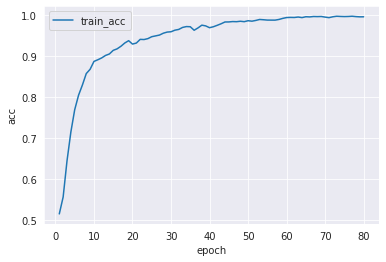

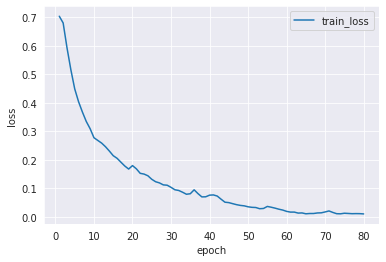

In [22]:
plotmodel(history,'mobilenetv2')         

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[136   7]
 [ 15  82]]
Classification Report
               precision    recall  f1-score   support

non-referable       0.90      0.95      0.93       143
    referable       0.92      0.85      0.88        97

     accuracy                           0.91       240
    macro avg       0.91      0.90      0.90       240
 weighted avg       0.91      0.91      0.91       240



Text(69.0, 0.5, 'Truth')

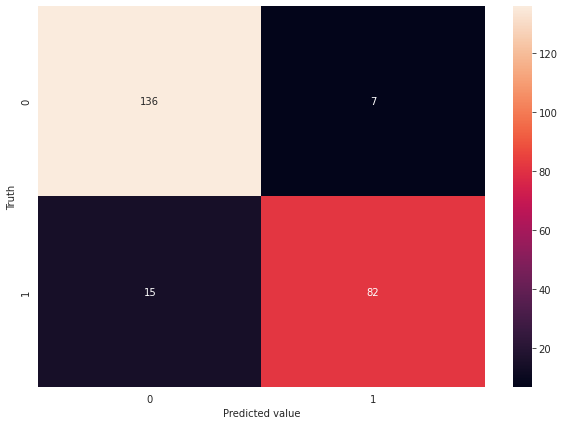

In [24]:
plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')   

In [25]:
pip install plot-metric

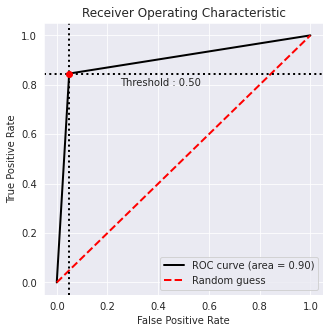

In [26]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
y_true = valid_data.classes
y_probas = y_pred
bc = BinaryClassification(y_true, y_probas, labels=['non-referable', 'referable'])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()